# Price stock regression 

## Setup 

In [4]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np

setup_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from tqdm.notebook import trange, tqdm

from helpers.data_helper import *

In [58]:
DATA_PATH = '../data/'
quotation = 'GOOG'
FILE_SUFFIX = '.txt'
price_column = 'Close'

THRESH_DIFF = 0.005

In [59]:
from datasets.stocks_data_wrapper import StocksDataWrapper
data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quotation}{FILE_SUFFIX}")
data_wrapper.compute_features(predict_n=10, thresh_diff=THRESH_DIFF)
data_wrapper.head()

,Date,Open,High,Low,Close,Volume,Adjusted,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,2007-02-21,234.042755,238.446243,232.996674,237.041504,11323400.0,237.041504,1.046081,50.702445,1.125778,...,232.409871,237.579495,234.937578,-6.248756,5.169624,2.181809,0.009290,higher,226.969269,stay
1,2007-02-22,238.451233,241.215866,236.309250,237.036530,11530700.0,237.036530,0.727280,50.694911,1.409729,...,232.700781,237.001162,235.217438,-5.027708,4.300381,2.909104,0.012425,stay,226.510986,stay
2,2007-02-23,236.986710,237.584473,233.026566,234.431290,7794200.0,234.431290,1.404724,46.774628,0.049820,...,232.680358,236.566042,235.112618,-4.384579,3.885685,-0.204239,-0.000870,lower,225.634262,stay
3,2007-02-26,235.532166,236.737656,231.009125,231.596924,7969500.0,231.596924,0.587799,42.888748,1.100876,...,232.831790,235.796178,234.643859,-3.598058,2.964388,1.514328,0.006582,lower,226.525925,stay
4,2007-02-27,226.650452,229.041489,222.750076,223.547089,18695300.0,223.547089,0.797013,34.198985,4.946472,...,232.357567,234.707758,233.164290,-3.750615,2.350191,-4.742233,-0.020773,lower,220.687805,lower


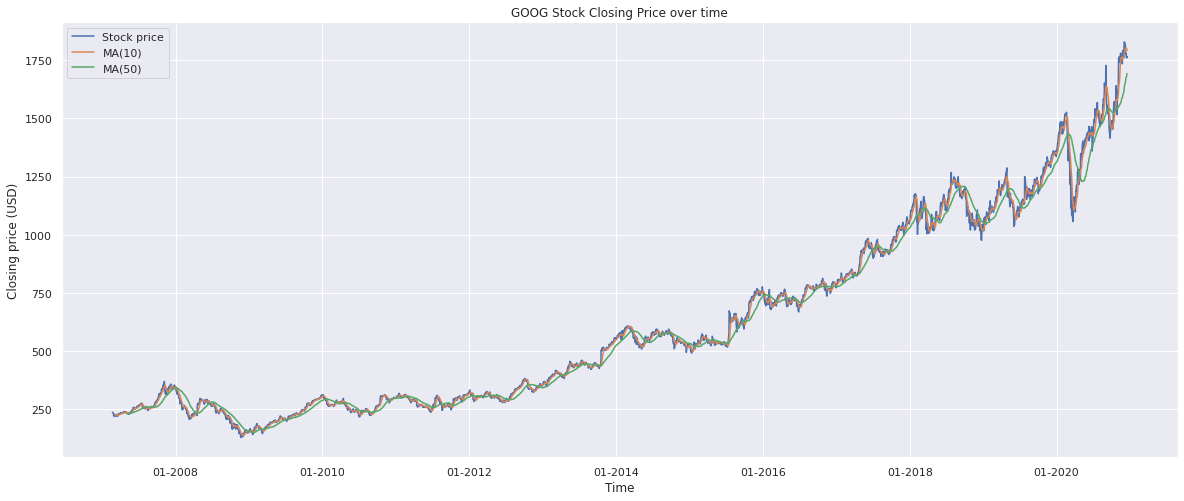

In [60]:
from helpers.plots_helper import plot_prices

ax = plot_prices(data_wrapper['Date'], data_wrapper[price_column], quotation_name=quotation, ma_values=[10,50])

### ML Data preparation

In [61]:
data_columns = ['Close', 'SMA(10)','Volume']

X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.3, 
                                                             y_column='NextPrice', 
                                                             features_list=data_columns)

### Classifier and evaluation

In [62]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [63]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = reg.predict(X_test)
print(f"MSE : {mean_squared_error(y_test, y_pred):.2f}")
print(f"R2_Score : {r2_score(y_test, y_pred):.2f}")

MSE : 3604.40
R2_Score : 0.94


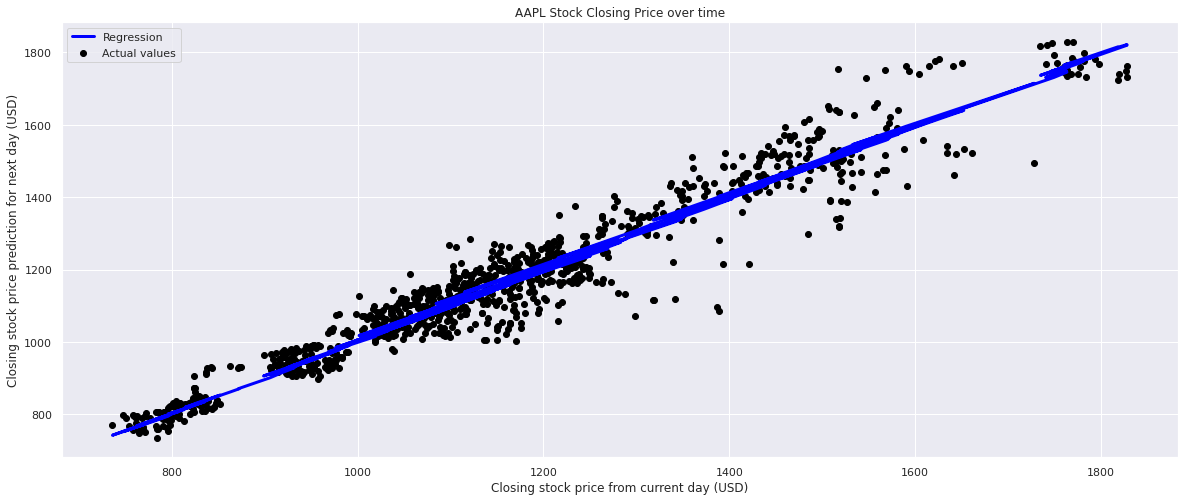

In [64]:
values = X_test[:, 0]
ax = plt.gca()
plt.scatter(values, y_test,  color='black', label="Actual values")
plt.plot(values, y_pred, color='blue', linewidth=3, label="Regression")

ax.set(title='AAPL Stock Closing Price over time', 
       ylabel='Closing stock price prediction for next day (USD)', xlabel='Closing stock price from current day (USD)')
plt.legend(loc='best')
plt.show()

### Build a dataframe for classification tests

In [65]:
actual_diff = [actual_next - closing_price for closing_price, actual_next in zip(X_test[:, 0], y_test)]
predicted_diff = [predicted_next - closing_price for closing_price, predicted_next in zip(X_test[:, 0], y_pred)]

df_test = pd.DataFrame({'ActualDiff': actual_diff, 'PredictedDiff':predicted_diff})
df_test.head()

,ActualDiff,PredictedDiff
0,-30.589965,-0.215132
1,-17.159973,0.879719
2,-13.760009,2.160760
3,-32.789978,2.399053
4,-41.349975,1.953103


### Compute the binned tendencies predicted and actual for the classification

In [67]:
df_test['ActualTendency'] = compute_tendency(df_test, thresh_diff=THRESH_DIFF, labels=['lower', 'stay', 'higher'])
df_test['PredictedTendency'] = compute_tendency(df_test, thresh_diff=THRESH_DIFF, labels=['lower', 'stay', 'higher'])

ValueError: Input array must be 1 dimensional

In [21]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score

accuracy = accuracy_score(df_test['ActualTendency'], df_test['PredictedTendency'])
f1 = f1_score(df_test['ActualTendency'], df_test['PredictedTendency'], average='weighted')

print(f"Accuracy : {accuracy:.2f}, F1 : {f1:.2f}")

Accuracy : 0.34, F1 : 0.30


In [69]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score

accuracy = accuracy_score(df_test['ActualTendency'], df_test['PredictedTendency'])
f1 = f1_score(df_test['ActualTendency'], df_test['PredictedTendency'], average='weighted')
print(f"Accuracy : {accuracy:.2f}, F1 : {f1:.2f}")


KeyError: 'ActualTendency'